In [1]:
%load_ext autoreload
%autoreload 2

#%config IPCompleter.greedy=True

# Rotation curves

First, imports:

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import h5py
from astropy import units
from pathlib import Path
import os
import astropy.units as u
from astropy.constants import G

import snapshot_obj 
import subhalo
import dataset_compute
import curve_fit

import importlib

In [3]:
importlib.reload(snapshot_obj)
importlib.reload(subhalo)
importlib.reload(dataset_compute)
importlib.reload(curve_fit)

<module 'curve_fit' from '/home/kassiili/Curvaton_Simulations/analysis/curve_fit.py'>

## Get data

In [4]:
snap_id = 127
sim_ids = ["V1_LR_fix", "V1_LR_curvaton_p082_fix", "V1_LR_curvaton_p084_fix"]
names = ["LCDM", "p082", "p084"]

# Which halo:
halo = [(1,0), (1,0), (1,0)]

In [5]:
snap_id = 127
sim_ids = ["V1_LR_fix", "V1_LR_curvaton_p082_fix"]
names = ["LCDM", "p082"]

# Which halo:
halo = [(2,0), (1,1)]

In [6]:
data = {}
for name, sim_id, halo_id in zip(names, sim_ids, halo):
    data[name] = {"snapshot": snapshot_obj.Snapshot(sim_id, snap_id, name=name),
                  "halo_identifier": halo_id}

In [7]:
pts = {'gas': 'PartType0', 
       'dm': 'PartType1', 
       'stars': 'PartType4', 
       'bh': 'PartType5', 
       'all': 'All'}
for name, sim_data in data.items():
    snap = sim_data["snapshot"]
    idx = snap.index_of_halo(sim_data["halo_identifier"][0], 
                             sim_data["halo_identifier"][1])

    data[name]['datasets'] = {pt: {} for pt in pts.keys()}
    for pt, pt_catalogue in pts.items():
        rot_curves = snap.get_subhalos('Vcirc', 
                                       group='Extended/RotationCurve/{}'\
                                       .format(pt_catalogue))
        sub_offset = snap.get_subhalos('SubOffset', 
                                       group='Extended/RotationCurve/{}'\
                                       .format(pt_catalogue))
        v_circ = rot_curves[:,0] * units.cm.to(units.km)
        radii = rot_curves[:,1] * units.cm.to(units.kpc)
    
        data[name]['datasets'][pt] = {"Vcirc": v_circ[sub_offset[idx]:sub_offset[idx+1]],
                                      "Radius": radii[sub_offset[idx]:sub_offset[idx+1]]}

In [8]:
# Set some parameters:
x_down = 0; x_up = 100
y_down = 0; y_up = 200

# Set line styles:
col_pairs = [("black", "gray"), ("red", "pink"), ("blue", "lightblue"),
             ("green", "lightgreen")]

line_style = {name: {'all': (c[1], ':'),
                       'dm': (c[0], '--'),
                       'stars': (c[0], '-'),
                       'gas': (c[1], '-'),
                       'bh': (c[1], '--')}
              for name, c in zip(names, col_pairs)}

In [9]:
# Construct saving location:
filename = 'rotation_curve_by_type'
for name, sim_data in data.items():
    filename += "_{}_gn{}sgn{}".format(name, sim_data["halo_identifier"][0],
                                       sim_data["halo_identifier"][1])
filename += ".png"
    
home = os.path.dirname(snapshot_obj.__file__)
path = os.path.join(home,"Figures")
filename = os.path.join(path, filename)

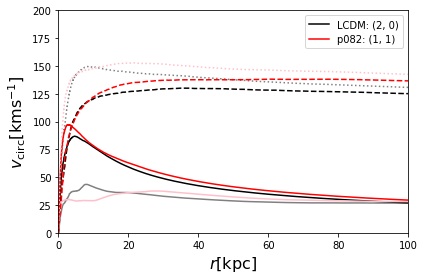

In [10]:
fig, axes = plt.subplots()

# Set axes:
axes.set_xlim(x_down, x_up)
axes.set_ylim(y_down,y_up)

# Set labels:
axes.set_xlabel('$r[\mathrm{kpc}]$', fontsize=16)
axes.set_ylabel('$v_{\mathrm{circ}}[\mathrm{kms^{-1}}]$', fontsize=16)

# Galaxy text:
#axes.set_title('Rotation curve: GN={}, SGN={}'.format(gn,sgn))


for i, (name, sim_data) in enumerate(data.items()):
    lab = "{}: ({}, {})".format(name, 
                                sim_data["halo_identifier"][0],
                                sim_data["halo_identifier"][1])
    axes.plot([], [], c=col_pairs[i][0], label=lab)
    for pt, pt_entry in sim_data['datasets'].items():
        col = line_style[name][pt][0]
        style = line_style[name][pt][1]
        axes.plot(pt_entry["Radius"], pt_entry["Vcirc"],
                  c=col, linestyle=style)

   
    
plt.legend()
plt.tight_layout()

plt.savefig(os.path.join(path,filename), dpi=200)